##### Time Series analysis
Notebook includes:

1. Sourcing data from quandl
2. Seasonal decomposition
3. Dickey-Fuller Stationarity test
4. Autocorrection check
5. Difference method for stationarity of data

In [1]:
#importing the necessary libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [3]:
quandl.ApiConfig.api_key = 'CFVKMLk7jnQ1DNvudxFC'

In [4]:
#Getting the data from quandl
#Exchange rates on BTIFinex exchange
#XRP/BTC Exchange Rate
data = quandl.get('BITFINEX/XRPBTC')

In [5]:
data.head()

,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2017-05-19,0.000200,0.000130,0.000164,0.000169,0.000159,0.000169,1.133802e+06
2017-05-20,0.000189,0.000147,0.000168,0.000168,0.000167,0.000169,4.924474e+06
2017-05-21,0.000178,0.000160,0.000163,0.000164,0.000162,0.000163,3.390939e+06
2017-05-22,0.000165,0.000115,0.000141,0.000141,0.000140,0.000141,8.063178e+06
2017-05-23,0.000159,0.000130,0.000145,0.000144,0.000143,0.000146,2.929714e+06


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1478 entries, 2017-05-19 to 2021-07-12
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    1478 non-null   float64
 1   Low     1478 non-null   float64
 2   Mid     1478 non-null   float64
 3   Last    1478 non-null   float64
 4   Bid     1478 non-null   float64
 5   Ask     1478 non-null   float64
 6   Volume  1478 non-null   float64
dtypes: float64(7)
memory usage: 92.4 KB


In [7]:
data.shape

(1478, 7)

In [8]:
data.columns

Index(['High', 'Low', 'Mid', 'Last', 'Bid', 'Ask', 'Volume'], dtype='object')

In [9]:
type(data)

pandas.core.frame.DataFrame

For this analysis the price of XRP to BTC at the end of the day (Last) is taken for further analysis

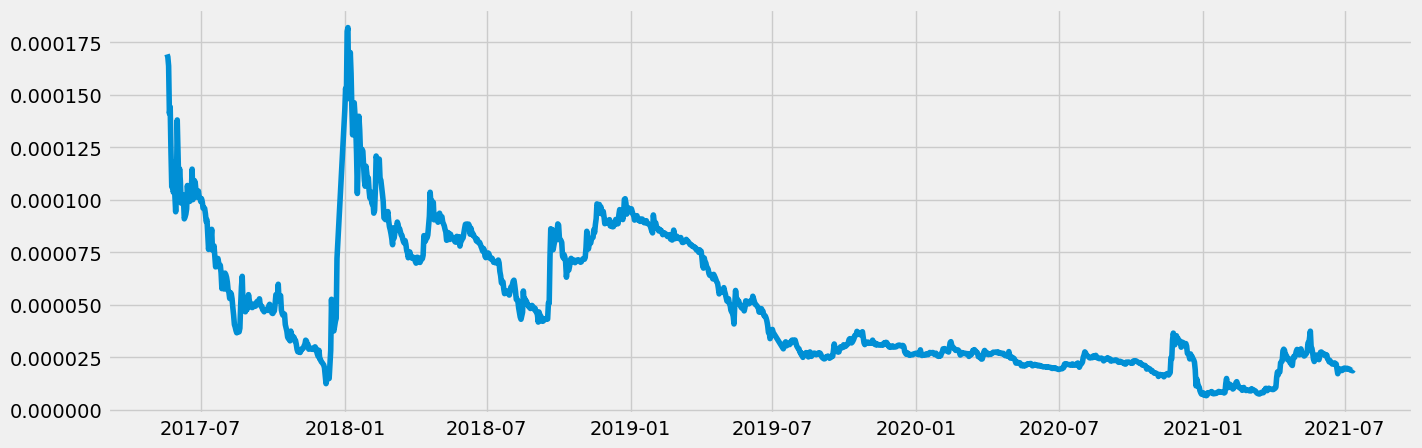

In [10]:
plt.figure(figsize=(15,5),dpi=100)
plt.plot(data['Last'])

In [11]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data['Last'], model='additive',period=1)
decomposition

In [12]:
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

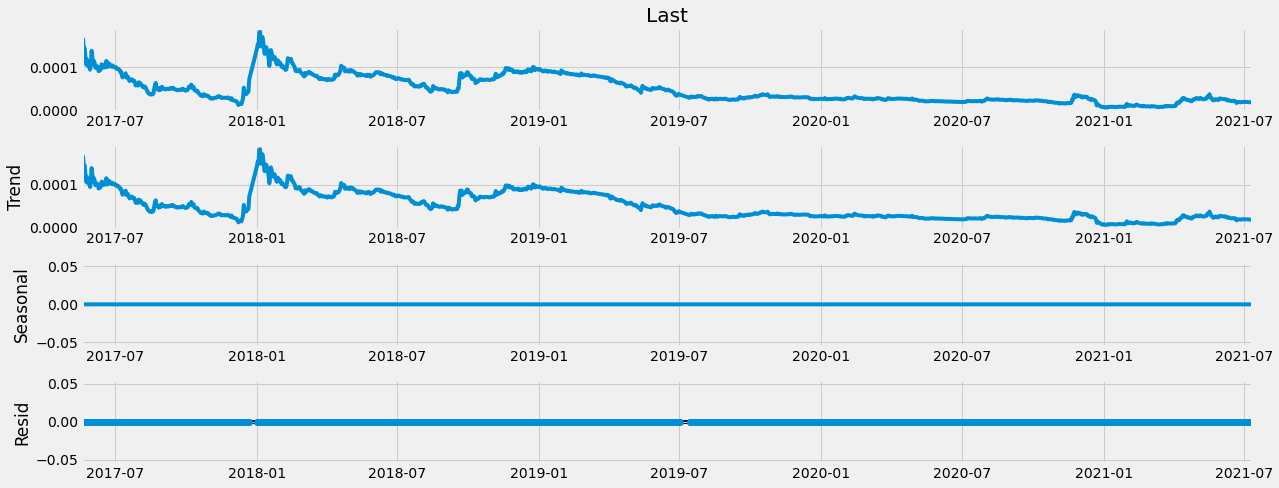

In [13]:
# Plot the separate components

decomposition.plot()
plt.show()

According to the decomposition of the time series, there is no seasonality and there is no unexplained noise. 

In [14]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key]=value
    print (result)
    
dickey_fuller(data['Last'])

Dickey-Fuller Stationarity test:
Test Statistic                   -2.609013
p-value                           0.091149
Number of Lags Used              20.000000
Number of Observations Used    1457.000000
Critical Value (1%)              -3.434846
Critical Value (5%)              -2.863526
Critical Value (10%)             -2.567827
dtype: float64


According to the Dickey-Fuller Test, the data is not stationary, p-value>0.05
Difference method of stationarity will performed on the data set

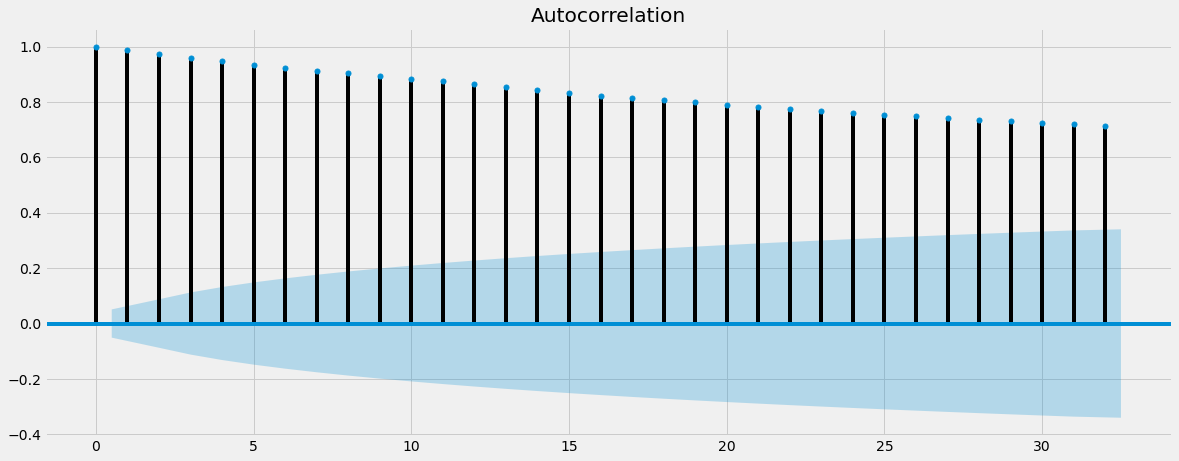

In [15]:
#Autocorrelation plot confirms that the data is not stationary
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['Last'])
plt.show()

In [16]:
#difference method for stationarity is applied of the data set
data_diff = data - data.shift(1)

In [17]:
data_diff.dropna(inplace = True)

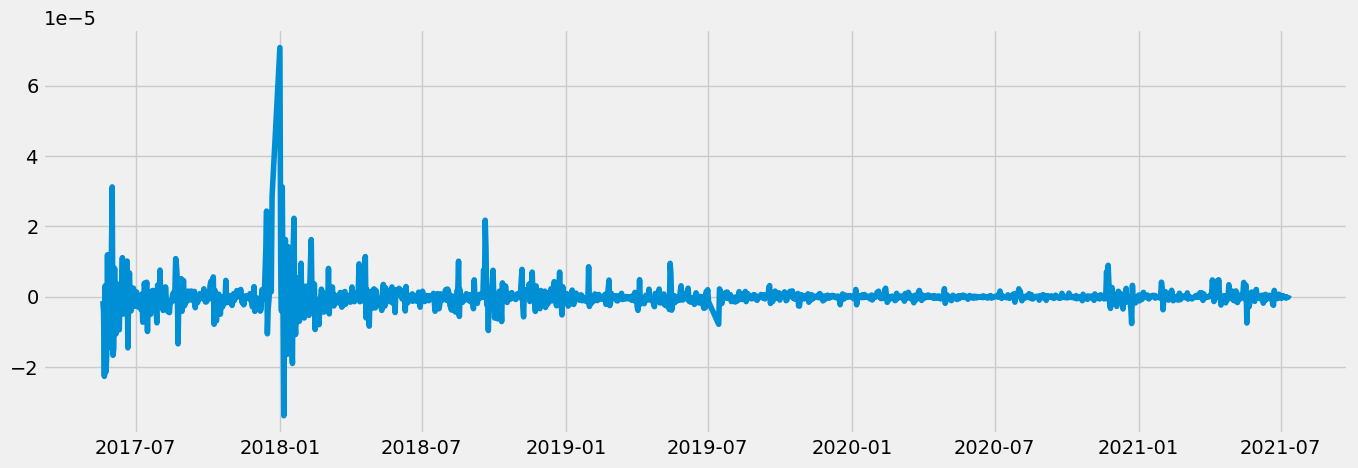

In [18]:
plt.figure(figsize=(15,5),dpi=100)
plt.plot(data_diff['Last'])

In [19]:
dickey_fuller(data_diff['Last'])

Dickey-Fuller Stationarity test:
Test Statistic                -9.494472e+00
p-value                        3.579560e-16
Number of Lags Used            1.900000e+01
Number of Observations Used    1.457000e+03
Critical Value (1%)           -3.434846e+00
Critical Value (5%)           -2.863526e+00
Critical Value (10%)          -2.567827e+00
dtype: float64


After a single itteration of the difference method, the data appears to be stationary. 
Dickey-Fuller test shows p-value<0.05 and both autocorrelation and partial autocorrlation do not show a lot of lag.

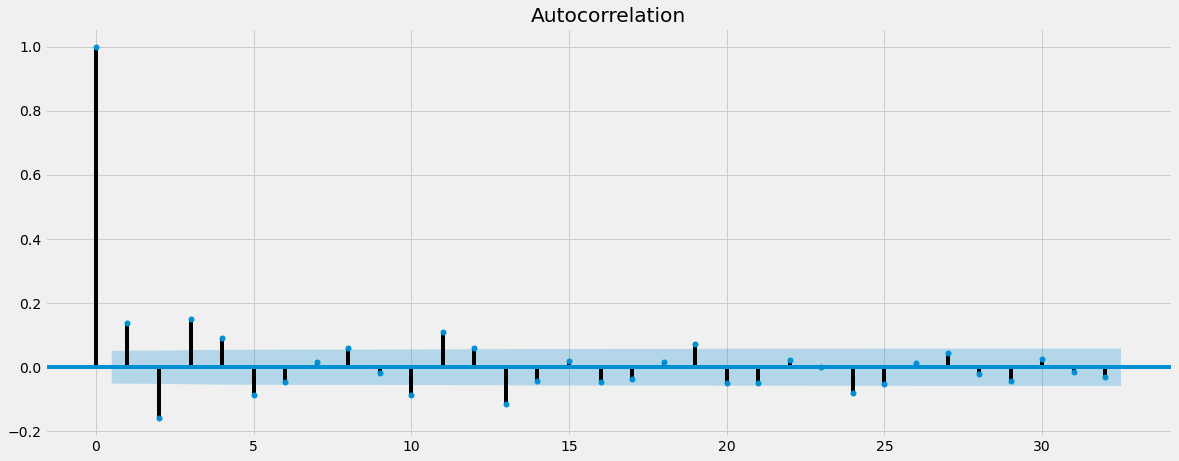

In [20]:
plot_acf(data_diff['Last'])
plt.show()

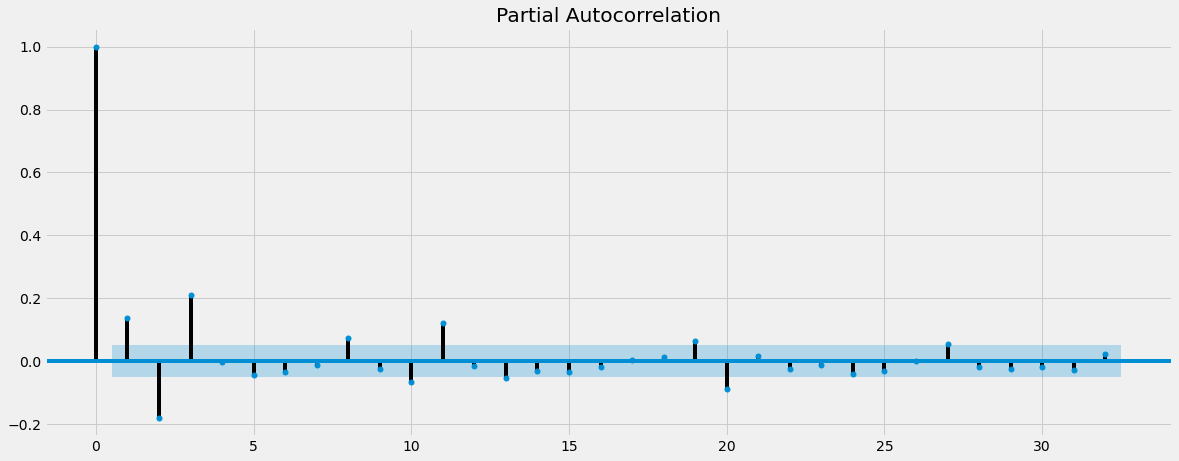

<Figure size 4500x4500 with 0 Axes>

In [21]:
plot_pacf(data_diff['Last'])
plt.figure(figsize=(15,15), dpi=300)
plt.show()

Choosing parameters:
    d=1    data became stationary after one itteration of the difference method
    p=5    according to the partial autocorrection plot
    q=5    according to the autocorrection plot

In [22]:
# slitting data

train = data_diff['Last'][:1103]
test = data_diff['Last'][1104:]

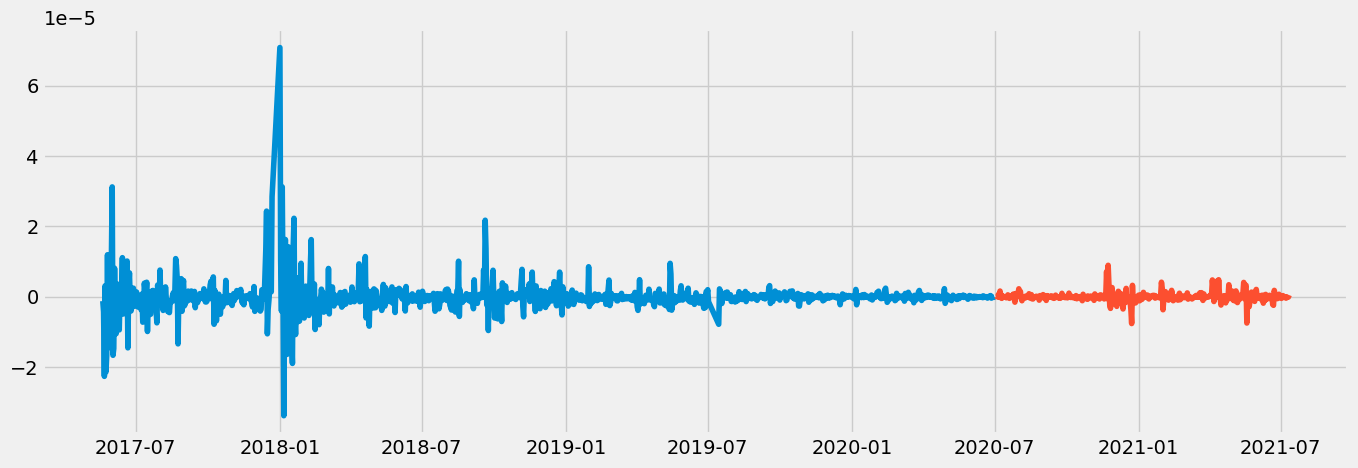

In [23]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [24]:
#ARIMA model (p,d,q)
from statsmodels.tsa.api import ARIMA

                             ARIMA Model Results                              
Dep. Variable:                 D.Last   No. Observations:                 1102
Model:                 ARIMA(5, 1, 5)   Log Likelihood               12061.777
Method:                       css-mle   S.D. of innovations              0.000
Date:                Tue, 13 Jul 2021   AIC                         -24099.553
Time:                        12:10:56   BIC                         -24039.495
Sample:                             1   HQIC                        -24076.835
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.539e-09   2.17e-08      0.071      0.944   -4.11e-08    4.41e-08
ar.L1.D.Last    -0.8113      0.068    -11.973      0.000      -0.944      -0.679
ar.L2.D.Last    -1.0819        nan        na

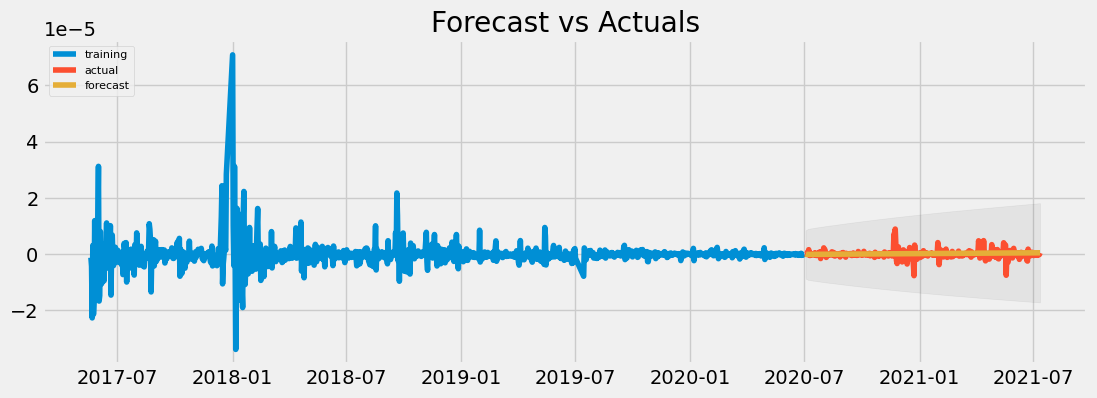

In [25]:
#ARIMA model used p=5, d=1, q=5 

model = ARIMA(train, order=(5,1,5))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(373, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0], index=test.index)
upper_series = pd.Series(conf[:,1], index=test.index)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [26]:
def forecast_accuracy(forecast,actual):
    mape = np.mean(np.abs(forecast-actual)/np.abs(actual))
    mae = np.mean(np.abs(forecast-actual))
    rmse = np.mean((forecast - actual)**2)**.5
    return({'mape':mape,'mae':mae, 'rmse':rmse})
forecast_accuracy(fc,test.values)

{'mape': inf, 'mae': 8.268708733018528e-07, 'rmse': 1.3747611096078173e-06}

                             ARIMA Model Results                              
Dep. Variable:                 D.Last   No. Observations:                 1102
Model:                 ARIMA(7, 1, 7)   Log Likelihood               12061.078
Method:                       css-mle   S.D. of innovations              0.000
Date:                Tue, 13 Jul 2021   AIC                         -24090.155
Time:                        12:11:03   BIC                         -24010.077
Sample:                             1   HQIC                        -24059.864
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          1.08e-09   1.96e-08      0.055      0.956   -3.73e-08    3.94e-08
ar.L1.D.Last    -0.4953        nan        nan        nan         nan         nan
ar.L2.D.Last    -1.0677        nan        na

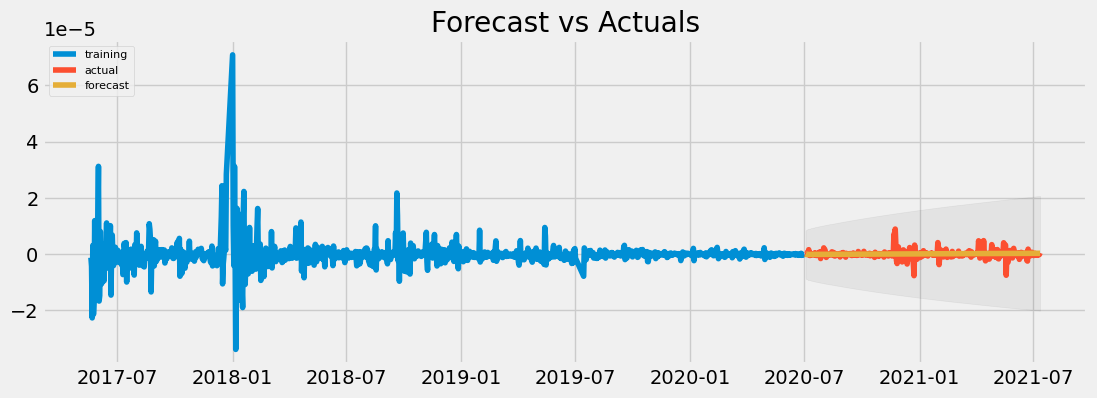

In [27]:
#ARIMA model used p=7, d=1, q=7 

model = ARIMA(train, order=(7,1,7))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(373, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0], index=test.index)
upper_series = pd.Series(conf[:,1], index=test.index)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [28]:
def forecast_accuracy(forecast,actual):
    mape = np.mean(np.abs(forecast-actual)/np.abs(actual))
    mae = np.mean(np.abs(forecast-actual))
    rmse = np.mean((forecast - actual)**2)**.5
    return({'mape':mape,'mae':mae, 'rmse':rmse})
forecast_accuracy(fc,test.values)

{'mape': inf, 'mae': 7.911651619878998e-07, 'rmse': 1.3564442165397956e-06}

                             ARIMA Model Results                              
Dep. Variable:                 D.Last   No. Observations:                 1102
Model:                 ARIMA(3, 1, 3)   Log Likelihood               12038.659
Method:                       css-mle   S.D. of innovations              0.000
Date:                Tue, 13 Jul 2021   AIC                         -24061.317
Time:                        12:11:09   BIC                         -24021.278
Sample:                             1   HQIC                        -24046.171
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          1.08e-09        nan        nan        nan         nan         nan
ar.L1.D.Last    -0.4073        nan        nan        nan         nan         nan
ar.L2.D.Last    -0.5364      0.051    -10.52

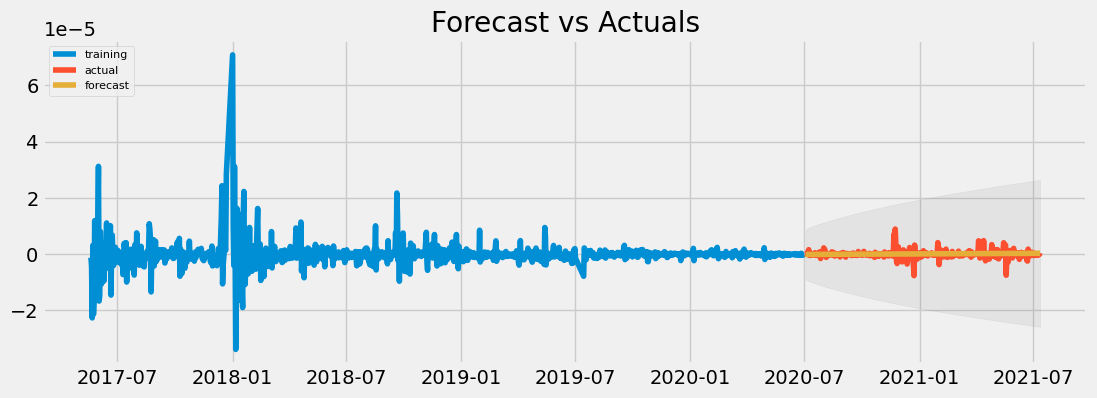

In [29]:
#ARIMA model used p=3, d=1, q=3 

model = ARIMA(train, order=(3,1,3))
fitted = model.fit()
print(fitted.summary())

fc, se, conf = fitted.forecast(373, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0], index=test.index)
upper_series = pd.Series(conf[:,1], index=test.index)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [30]:
def forecast_accuracy(forecast,actual):
    mape = np.mean(np.abs(forecast-actual)/np.abs(actual))
    mae = np.mean(np.abs(forecast-actual))
    rmse = np.mean((forecast - actual)**2)**.5
    return({'mape':mape,'mae':mae, 'rmse':rmse})
forecast_accuracy(fc,test.values)

{'mape': inf, 'mae': 7.893664836413757e-07, 'rmse': 1.3558117920731544e-06}

The error terms are very small for all of the ARIMA models created by the algorithm. 